In [1]:
!pip install keras torch scikit-learn pandas matplotlib --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 758.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.2 MB/s eta 0:00:00


In [2]:
!pip install pymorphy3 --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 50.3 MB/s eta 0:00:00


# Домашнее задание № 8

## Задание 1 (4 балла)

Обучите 2 модели похожую по архитектуре на модель из ULMFit для задачи классификации текста (датасет - lenta_40k )
В моделях должно быть как минимум два рекуррентных слоя, а финальный вектор для классификации составляться из последнего состояния RNN (так делалось в семинаре), а также AveragePooling и MaxPooling из всех векторов последовательности (конкатенируйте последнее состояния и результаты пулинга). В первой модели используйте обычные слои, а во второй Bidirectional. Рассчитайте по классовую точность/полноту/f-меру для каждой из модели (результаты не должны быть совсем близкие к нулю после обучения на хотя бы нескольких эпохах).

In [3]:
import os
os.environ["KERAS_BACKEND"] = "torch"

In [4]:
import keras
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import torch

In [6]:
data = pd.read_csv('lenta_40k.csv')
data

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия
...,...,...
44351,Российский Минфин может пересмотреть минимальн...,Экономика
44352,Сотрудники Службы безопасности Украины (СБУ) с...,Бывший СССР
44353,Америке следует задуматься над поставками на У...,Силовые структуры
44354,"Опознаны тела 71 человека, погибшего в результ...",Мир


In [6]:
from google.colab import drive
import pickle
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
with open("/content/drive/MyDrive/filtered_vocab_lenta.pkl", 'rb') as f:
    filtered_vocab = pickle.load(f)

In [ ]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

In [21]:
with open("/content/drive/MyDrive/lenta_ids.pkl", "rb") as f:
    X = pickle.load(f)

In [19]:
MAX_LEN = max(len(x) for x in X)
MAX_LEN

1742

In [ ]:
MEAN_LEN = np.median([len(x) for x in X])
MEAN_LEN

175.0

In [20]:
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [ ]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [ ]:
X.shape

(20000, 1742)

In [ ]:
y = keras.utils.to_categorical([label2id[label] for label in data[:20000].topic.values])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, random_state=42)

In [24]:
checkpoint = keras.callbacks.ModelCheckpoint('rnn_model.weights.h5', # названия файла
                                                monitor='val_rec@prec', # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode='max', # если метрика должна расти, то тут max и min если наоборот
                                                save_freq='epoch' # как часто вызывать
                                               )

# EarlyStopping позволяет автоматически остановить обучение, если качество не улучшается
early_stop = keras.callbacks.EarlyStopping(monitor='val_rec@prec',
                                              min_delta=0.01, # какая разница считается как улучшение
                                              patience=5, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1,
                                              mode='max',
                                              )

In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=50)(inputs, )

rnn1 = keras.layers.LSTM(100, return_sequences=True)(embeddings)
rnn2 = keras.layers.LSTM(100, return_sequences=True)(rnn1)
avg_pool = keras.layers.GlobalAveragePooling1D()(rnn2)
max_pool = keras.layers.GlobalMaxPooling1D()(rnn2)

concat = keras.layers.concatenate([rnn2[:, -1, :], avg_pool, max_pool])
outputs = keras.layers.Dense(len(label2id), activation="softmax")(concat)

In [ ]:
model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=[keras.metrics.RecallAtPrecision(0.8, name="rec@prec")])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1742)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 1742, 50)       │        715,900 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 1742, 100)      │         60,400 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 1742, 100)      │         80,400 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 100)            │              0 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 100)            │              0 │ lstm_1[0][0]           │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 100)            │              0 │ lstm_1[0][0]           │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 300)            │              0 │ get_item[0][0],        │
│                           │                        │                │ global_average_poolin… │
│                           │                        │                │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 19)             │          5,719 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 862,419 (3.29 MB)

 Trainable params: 862,419 (3.29 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=128,
          epochs=15,
          callbacks=[checkpoint, early_stop])

Epoch 1/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 2.3156 - rec@prec: 0.0049
Epoch 1: val_rec@prec improved from -inf to 0.09900, saving model to rnn_model.weights.h5
149/149 ━━━━━━━━━━━━━━━━━━━━ 680s 5s/step - loss: 2.3139 - rec@prec: 0.0051 - val_loss: 1.8025 - val_rec@prec: 0.0990
Epoch 2/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 1.6135 - rec@prec: 0.1323
Epoch 2: val_rec@prec improved from 0.09900 to 0.17100, saving model to rnn_model.weights.h5
149/149 ━━━━━━━━━━━━━━━━━━━━ 667s 4s/step - loss: 1.6129 - rec@prec: 0.1325 - val_loss: 1.4835 - val_rec@prec: 0.1710
Epoch 3/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 1.2350 - rec@prec: 0.3486
Epoch 3: val_rec@prec improved from 0.17100 to 0.39400, saving model to rnn_model.weights.h5
149/149 ━━━━━━━━━━━━━━━━━━━━ 663s 4s/step - loss: 1.2347 - rec@prec: 0.3490 - val_loss: 1.2803 - val_rec@prec: 0.3940
Epoch 4/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.9170 - rec@prec: 0.6621
Epoch 4: val_rec@prec improved

KeyboardInterrupt: 

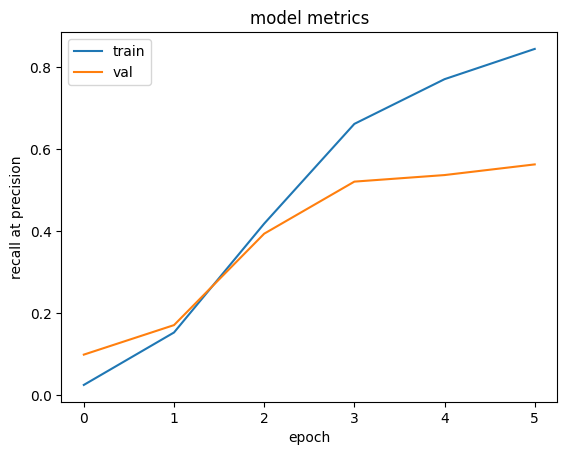

In [ ]:
plt.plot(model.history.history["rec@prec"])
plt.plot(model.history.history["val_rec@prec"])
plt.title("model metrics")
plt.ylabel("recall at precision")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [ ]:
pred = model.predict(X_valid).argmax(1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_valid.argmax(1), pred, labels=list(id2label.keys()),
                                                                     target_names=list(id2label.values()),
                                                                     zero_division=0))

                   precision    recall  f1-score   support

             Крым       0.00      0.00      0.00         1
           Россия       0.68      0.73      0.71       235
              Мир       0.69      0.68      0.68       166
      Бывший СССР       0.63      0.75      0.68        59
      Путешествия       0.00      0.00      0.00        14
Силовые структуры       0.08      0.04      0.05        25
   Интернет и СМИ       0.35      0.56      0.43        66
         Из жизни       0.34      0.25      0.29        44
        Экономика       0.78      0.75      0.76       115
          Легпром       0.00      0.00      0.00         0
         Ценности       0.45      0.50      0.48        10
            Спорт       0.93      0.95      0.94        75
              Дом       0.67      0.61      0.63        33
    Культпросвет        0.00      0.00      0.00         0
   69-я параллель       0.00      0.00      0.00         1
  Наука и техника       0.72      0.79      0.75       

In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=50)(inputs, )

rnn1 = keras.layers.Bidirectional(keras.layers.LSTM(100, return_sequences=True))(embeddings)
rnn2 = keras.layers.Bidirectional(keras.layers.LSTM(100, return_sequences=True))(rnn1)
avg_pool = keras.layers.GlobalAveragePooling1D()(rnn2)
max_pool = keras.layers.GlobalMaxPooling1D()(rnn2)

concat = keras.layers.concatenate([rnn2[:, -1, :], avg_pool, max_pool])
outputs = keras.layers.Dense(len(label2id), activation="softmax")(concat)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=[keras.metrics.RecallAtPrecision(0.8, name="rec@prec")])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 1742)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 1742, 50)       │        715,900 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 1742, 200)      │        120,800 │ embedding_2[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 1742, 200)      │        240,800 │ bidirectional[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 200)            │              0 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 200)            │              0 │ bidirectional_1[0][0]  │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_1    │ (None, 200)            │              0 │ bidirectional_1[0][0]  │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 600)            │              0 │ get_item_1[0][0],      │
│ (Concatenate)             │                        │                │ global_average_poolin… │
│                           │                        │                │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 19)             │         11,419 │ concatenate_1[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,088,919 (4.15 MB)

 Trainable params: 1,088,919 (4.15 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=128,
          epochs=6,
          callbacks=[checkpoint, early_stop])

Epoch 1/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 2.3501 - rec@prec: 0.0011
Epoch 1: val_rec@prec did not improve from 0.56300
149/149 ━━━━━━━━━━━━━━━━━━━━ 1423s 10s/step - loss: 2.3484 - rec@prec: 0.0011 - val_loss: 1.7116 - val_rec@prec: 0.0960
Epoch 2/6
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 1.4511 - rec@prec: 0.2492
Epoch 2: val_rec@prec did not improve from 0.56300
149/149 ━━━━━━━━━━━━━━━━━━━━ 1412s 9s/step - loss: 1.4504 - rec@prec: 0.2500 - val_loss: 1.2102 - val_rec@prec: 0.4420
Epoch 3/6
 72/149 ━━━━━━━━━━━━━━━━━━━━ 11:46 9s/step - loss: 1.0039 - rec@prec: 0.5891

KeyboardInterrupt: 

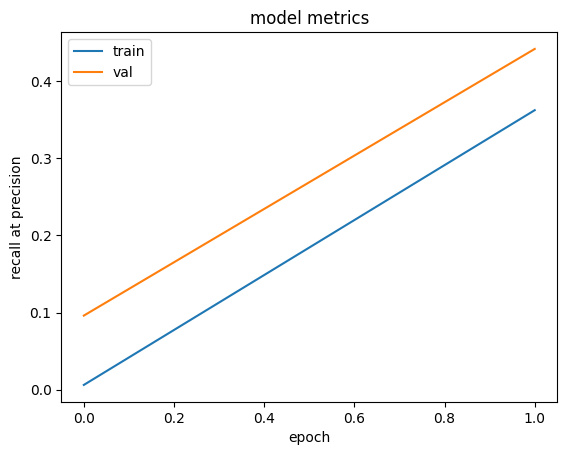

In [ ]:
plt.plot(model.history.history["rec@prec"])
plt.plot(model.history.history["val_rec@prec"])
plt.title("model metrics")
plt.ylabel("recall at precision")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [ ]:
pred = model.predict(X_valid).argmax(1)
print(classification_report(y_valid.argmax(1), pred, labels=list(id2label.keys()),
                                                                     target_names=list(id2label.values()),
                                                                     zero_division=0))

32/32 ━━━━━━━━━━━━━━━━━━━━ 168s 5s/step
                   precision    recall  f1-score   support

             Крым       0.00      0.00      0.00         1
           Россия       0.66      0.80      0.72       235
              Мир       0.61      0.80      0.69       166
      Бывший СССР       0.62      0.22      0.33        59
      Путешествия       0.00      0.00      0.00        14
Силовые структуры       0.00      0.00      0.00        25
   Интернет и СМИ       0.40      0.26      0.31        66
         Из жизни       0.44      0.27      0.34        44
        Экономика       0.66      0.86      0.75       115
          Легпром       0.00      0.00      0.00         0
         Ценности       0.00      0.00      0.00        10
            Спорт       0.94      0.96      0.95        75
              Дом       0.44      0.36      0.40        33
    Культпросвет        0.00      0.00      0.00         0
   69-я параллель       0.00      0.00      0.00         1
  Наука и техни

## Задание 2 (6 баллов)


На данных википедии (wikiann) обучите и сравните 3 модели:  
1) модель в которой как минимум два рекуррентных слоя, причем один из них GRU, а другой LSTM
2) модель в которой как минимум 3 рекуррентных слоя идут друг за другом и при этом 2-ой и 3-й слои еще имеют residual connection к изначальным эмбедингам. Для того, чтобы сделать residual connection вам нужно будет использовать одинаковую размерность эмбедингов и количество unit'ов в RNN слоях, чтобы их можно было просуммировать
3) модель в которой будут и рекуррентные и сверточные слои (как минимум 2 rnn и как минимум 2 cnn слоя). В cnn слоях будьте аккуратны с укорачиванием последовательности и используйте паддинг



Сравните качество по метрикам (точность/полнота/f-мера). Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.

In [7]:
!pip install datasets --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.2 MB/s eta 0:00:00


In [8]:
from datasets import load_dataset

dataset = load_dataset("tner/wikiann", 'ru')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/12.7k [00:00<?, ?B/s]

wikiann.py:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

The repository for tner/wikiann contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/tner/wikiann.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


test.jsonl:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/5.26M [00:00<?, ?B/s]

dev.jsonl:   0%|          | 0.00/2.63M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [9]:
vocab = Counter()

for sent in dataset["train"]["tokens"]:
    vocab.update([x.lower() for x in sent])

In [10]:
word2id = {"PAD": 0, "UNK": 1}

In [11]:
for word in vocab:
    word2id[word] = len(word2id)

In [12]:
id2word = {i:word for word, i in word2id.items()}

In [13]:
X = []

for sent in dataset["train"]["tokens"]:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [14]:
X_test = []

for sent in dataset["test"]["tokens"]:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)

In [15]:
MAX_LEN = max(len(x) for x in X)

In [16]:
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding="post")
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding="post")

In [17]:
label2id = {
    "B-LOC": 0,
    "B-ORG": 1,
    "B-PER": 2,
    "I-LOC": 3,
    "I-ORG": 4,
    "I-PER": 5,
    "O": 6,
    "PAD": 7
}
id2labels = {v:k for k,v in label2id.items()}

In [18]:
y = keras.preprocessing.sequence.pad_sequences(dataset["train"]["tags"], value=7,
                                                  maxlen=MAX_LEN, padding="post")
y_test = keras.preprocessing.sequence.pad_sequences(dataset["test"]["tags"], value=7,
                                                       maxlen=MAX_LEN, padding="post")

## Модель 1

In [30]:
import re

def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall("\w+|[^\w\s]+", text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(keras.preprocessing.sequence.pad_sequences([ids],
                                                                       maxlen=max_len,
                                                                       padding="post"))
    labels = pred2tags(pred, id2label, len(ids))

    return list(zip(tokens, labels))

In [20]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

rnn1 = keras.layers.LSTM(128, return_sequences=True)(embeddings)
rnn2 = keras.layers.GRU(128, return_sequences=True)(rnn1)

outputs = keras.layers.Dense(len(label2id), activation="softmax")(rnn2)

In [22]:
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [25]:
model.fit(X, y,
          validation_data=(X_test, y_test),
          batch_size=128,
          epochs=5,
          callbacks=[checkpoint, early_stop])

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 238ms/step - accuracy: 0.8545 - loss: 0.5799 - val_accuracy: 0.9407 - val_loss: 0.1980
Epoch 2/5
  1/157 ━━━━━━━━━━━━━━━━━━━━ 24s 157ms/step - accuracy: 0.9394 - loss: 0.1958

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_rec@prec available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_rec@prec` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 216ms/step - accuracy: 0.9450 - loss: 0.1753 - val_accuracy: 0.9639 - val_loss: 0.1058
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 49s 313ms/step - accuracy: 0.9731 - loss: 0.0780 - val_accuracy: 0.9711 - val_loss: 0.0804
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 231ms/step - accuracy: 0.9867 - loss: 0.0396 - val_accuracy: 0.9758 - val_loss: 0.0788
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 227ms/step - accuracy: 0.9934 - loss: 0.0210 - val_accuracy: 0.9775 - val_loss: 0.0823


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


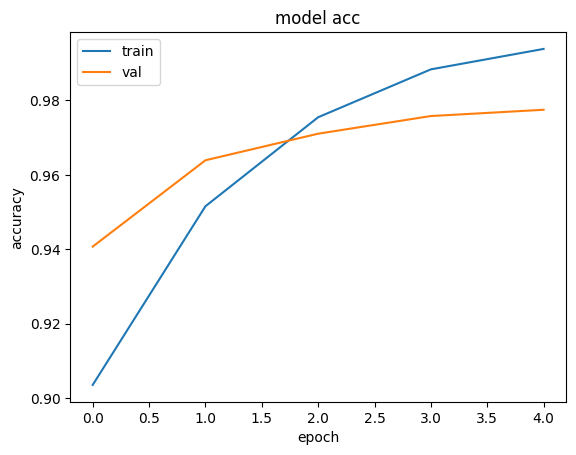

In [26]:
print(model.history.history.keys())
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
from sklearn.metrics import classification_report

pred = model.predict(X_test).argmax(2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 95ms/step


In [28]:
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

       B-LOC       0.68      0.62      0.65      4560
       B-ORG       0.46      0.62      0.53      4074
       B-PER       0.60      0.72      0.66      3542
       I-LOC       0.86      0.50      0.63      3060
       I-ORG       0.70      0.79      0.74      8008
       I-PER       0.91      0.90      0.90      7544
           O       0.94      0.90      0.92     40480
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.98    540000
   macro avg       0.77      0.76      0.75    540000
weighted avg       0.98      0.98      0.98    540000



In [31]:
label_seq(
    "Глава ЦБ Эльвира Набиуллина считает преждевременным говорить о возвращении Visa и Mastercard в РФ",
    word2id, id2labels, MAX_LEN, model
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


[('Глава', 'O'),
 ('ЦБ', 'O'),
 ('Эльвира', 'B-PER'),
 ('Набиуллина', 'I-PER'),
 ('считает', 'O'),
 ('преждевременным', 'O'),
 ('говорить', 'O'),
 ('о', 'O'),
 ('возвращении', 'O'),
 ('Visa', 'O'),
 ('и', 'O'),
 ('Mastercard', 'O'),
 ('в', 'O'),
 ('РФ', 'O')]

Модель не распознала ЦБ, Visa, Mastercard и РФ, но распознала Эльвиру Набиуллину

In [32]:
label_seq(
    "Внутри РФ карты Visa и Mastercard российских банков продолжают работать, так как операции по ним с 2015 года обрабатывает Национальная система платежных карт (НСПК).",
    word2id, id2labels, MAX_LEN, model
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


[('Внутри', 'O'),
 ('РФ', 'O'),
 ('карты', 'O'),
 ('Visa', 'O'),
 ('и', 'O'),
 ('Mastercard', 'B-ORG'),
 ('российских', 'O'),
 ('банков', 'O'),
 ('продолжают', 'B-ORG'),
 ('работать', 'O'),
 (',', 'O'),
 ('так', 'O'),
 ('как', 'O'),
 ('операции', 'B-ORG'),
 ('по', 'O'),
 ('ним', 'O'),
 ('с', 'O'),
 ('2015', 'B-ORG'),
 ('года', 'I-ORG'),
 ('обрабатывает', 'O'),
 ('Национальная', 'B-ORG'),
 ('система', 'I-ORG'),
 ('платежных', 'O'),
 ('карт', 'O'),
 ('(', 'O'),
 ('НСПК', 'B-ORG'),
 (').', 'I-ORG')]

Тут модель внезапно распознала Mastercard, ошибочно распознала некоторые элементы как именованные сущности (и я не могу найти хоть какой-то логики тут), Национальную систему платёжных карт включила в одну именованную сущность неполностью, но аббревиатура распознана

In [33]:
label_seq(
    "Глава ФРБ Атланты ожидает двух снижений базовой ставки ФРС в этом году",
    word2id, id2labels, MAX_LEN, model
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


[('Глава', 'O'),
 ('ФРБ', 'O'),
 ('Атланты', 'O'),
 ('ожидает', 'I-ORG'),
 ('двух', 'O'),
 ('снижений', 'O'),
 ('базовой', 'O'),
 ('ставки', 'O'),
 ('ФРС', 'O'),
 ('в', 'O'),
 ('этом', 'O'),
 ('году', 'O')]

Ни одна сущность не распознана, есть ложно позитивный результат

## Модель 2


In [56]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

rnn1 = keras.layers.LSTM(100, return_sequences=True)(embeddings)
residual1 = keras.layers.add([embeddings, rnn1])
rnn2 = keras.layers.LSTM(100, return_sequences=True)(residual1)
residual2 = keras.layers.add([embeddings, rnn2])
rnn3 = keras.layers.LSTM(100, return_sequences=True)(rnn2)

outputs = keras.layers.Dense(len(label2id), activation="softmax")(rnn3)

In [57]:
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [58]:
model.fit(X, y,
          validation_data=(X_test, y_test),
          batch_size=128,
          epochs=5,
          callbacks=[checkpoint, early_stop])

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 44s 280ms/step - accuracy: 0.8490 - loss: 0.6015 - val_accuracy: 0.9393 - val_loss: 0.2127
Epoch 2/5


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_rec@prec available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_rec@prec` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 44s 282ms/step - accuracy: 0.9420 - loss: 0.1953 - val_accuracy: 0.9518 - val_loss: 0.1492
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 44s 283ms/step - accuracy: 0.9617 - loss: 0.1160 - val_accuracy: 0.9694 - val_loss: 0.0905
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 44s 281ms/step - accuracy: 0.9810 - loss: 0.0558 - val_accuracy: 0.9702 - val_loss: 0.0864
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 44s 283ms/step - accuracy: 0.9885 - loss: 0.0339 - val_accuracy: 0.9725 - val_loss: 0.0863


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


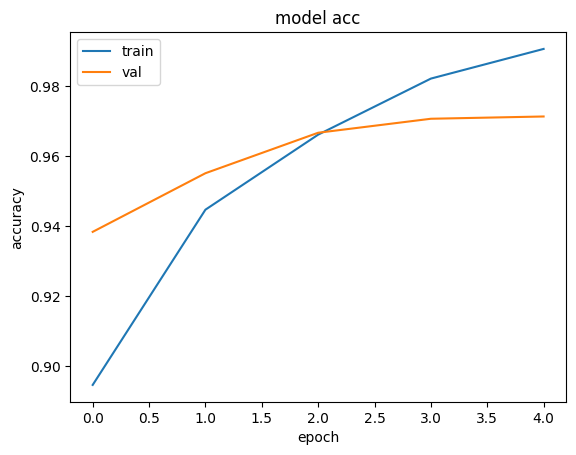

In [41]:
print(model.history.history.keys())
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [59]:
pred = model.predict(X_test).argmax(2)
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 124ms/step
              precision    recall  f1-score   support

       B-LOC       0.59      0.60      0.59      4560
       B-ORG       0.42      0.43      0.43      4074
       B-PER       0.65      0.26      0.37      3542
       I-LOC       0.76      0.50      0.61      3060
       I-ORG       0.51      0.80      0.63      8008
       I-PER       0.91      0.86      0.88      7544
           O       0.93      0.90      0.92     40480
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.97    540000
   macro avg       0.72      0.67      0.68    540000
weighted avg       0.97      0.97      0.97    540000



In [42]:
label_seq(
    "Глава ЦБ Эльвира Набиуллина считает преждевременным говорить о возвращении Visa и Mastercard в РФ",
    word2id, id2labels, MAX_LEN, model
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


[('Глава', 'O'),
 ('ЦБ', 'O'),
 ('Эльвира', 'B-PER'),
 ('Набиуллина', 'I-PER'),
 ('считает', 'O'),
 ('преждевременным', 'O'),
 ('говорить', 'O'),
 ('о', 'O'),
 ('возвращении', 'O'),
 ('Visa', 'O'),
 ('и', 'O'),
 ('Mastercard', 'O'),
 ('в', 'O'),
 ('РФ', 'O')]

Результат такой же, как и у первой модели

In [43]:
label_seq(
    "Внутри РФ карты Visa и Mastercard российских банков продолжают работать, так как операции по ним с 2015 года обрабатывает Национальная система платежных карт (НСПК).",
    word2id, id2labels, MAX_LEN, model
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


[('Внутри', 'O'),
 ('РФ', 'I-ORG'),
 ('карты', 'O'),
 ('Visa', 'B-ORG'),
 ('и', 'O'),
 ('Mastercard', 'B-ORG'),
 ('российских', 'O'),
 ('банков', 'O'),
 ('продолжают', 'B-ORG'),
 ('работать', 'O'),
 (',', 'O'),
 ('так', 'O'),
 ('как', 'O'),
 ('операции', 'B-ORG'),
 ('по', 'O'),
 ('ним', 'O'),
 ('с', 'O'),
 ('2015', 'B-ORG'),
 ('года', 'I-ORG'),
 ('обрабатывает', 'O'),
 ('Национальная', 'I-ORG'),
 ('система', 'I-ORG'),
 ('платежных', 'O'),
 ('карт', 'O'),
 ('(', 'O'),
 ('НСПК', 'O'),
 (').', 'O')]

Внезапно распознались РФ, Visa и Mastercard, ложноположительные срабатывания в тех же местах, что и у первой модели, тоже не полностью распознал НСПК, аббревиатура не распознана

In [44]:
label_seq(
    "Глава ФРБ Атланты ожидает двух снижений базовой ставки ФРС в этом году",
    word2id, id2labels, MAX_LEN, model
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


[('Глава', 'O'),
 ('ФРБ', 'O'),
 ('Атланты', 'O'),
 ('ожидает', 'O'),
 ('двух', 'O'),
 ('снижений', 'O'),
 ('базовой', 'O'),
 ('ставки', 'O'),
 ('ФРС', 'O'),
 ('в', 'O'),
 ('этом', 'O'),
 ('году', 'B-ORG')]

Почему-то год -- это именованная сущность

## Модель 3

In [48]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

rnn1 = keras.layers.LSTM(100, return_sequences=True)(embeddings)
сnn1 = keras.layers.Conv1D(kernel_size=5, filters=128, padding='same',strides=1)(rnn1)
rnn2 = keras.layers.LSTM(100, return_sequences=True)(сnn1)
сnn2 = keras.layers.Conv1D(kernel_size=5, filters=128, padding='same',strides=1)(rnn2)

outputs = keras.layers.Dense(len(label2id), activation="softmax")(сnn2)

In [49]:
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [50]:
model.fit(X, y,
          validation_data=(X_test, y_test),
          batch_size=128,
          epochs=5,
          callbacks=[checkpoint, early_stop])

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 242ms/step - accuracy: 0.8722 - loss: 0.4231 - val_accuracy: 0.9553 - val_loss: 0.1430
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 202ms/step - accuracy: 0.9622 - loss: 0.1172 - val_accuracy: 0.9738 - val_loss: 0.0840
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 195ms/step - accuracy: 0.9834 - loss: 0.0511 - val_accuracy: 0.9826 - val_loss: 0.0585
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 198ms/step - accuracy: 0.9953 - loss: 0.0161 - val_accuracy: 0.9847 - val_loss: 0.0569
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 199ms/step - accuracy: 0.9979 - loss: 0.0077 - val_accuracy: 0.9846 - val_loss: 0.0657


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


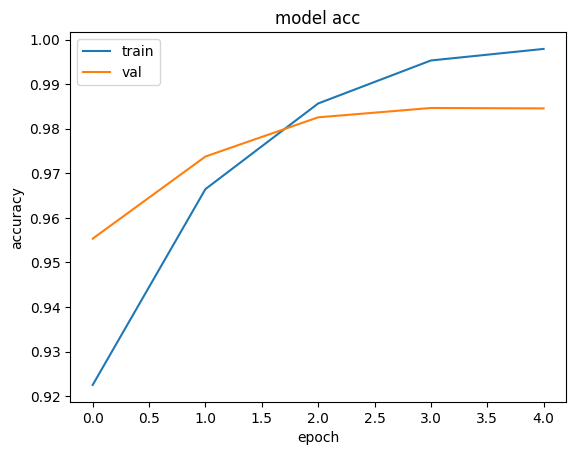

In [51]:
print(model.history.history.keys())
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [55]:
pred = model.predict(X_test).argmax(2)
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step
              precision    recall  f1-score   support

       B-LOC       0.71      0.78      0.74      4560
       B-ORG       0.74      0.66      0.70      4074
       B-PER       0.86      0.87      0.86      3542
       I-LOC       0.85      0.73      0.79      3060
       I-ORG       0.88      0.74      0.80      8008
       I-PER       0.93      0.83      0.88      7544
           O       0.91      0.97      0.94     40480
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.98    540000
   macro avg       0.86      0.82      0.84    540000
weighted avg       0.98      0.98      0.98    540000



In [52]:
label_seq(
    "Глава ЦБ Эльвира Набиуллина считает преждевременным говорить о возвращении Visa и Mastercard в РФ",
    word2id, id2labels, MAX_LEN, model
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


[('Глава', 'O'),
 ('ЦБ', 'B-PER'),
 ('Эльвира', 'I-PER'),
 ('Набиуллина', 'O'),
 ('считает', 'O'),
 ('преждевременным', 'O'),
 ('говорить', 'O'),
 ('о', 'O'),
 ('возвращении', 'O'),
 ('Visa', 'O'),
 ('и', 'O'),
 ('Mastercard', 'O'),
 ('в', 'O'),
 ('РФ', 'B-ORG')]

"ЦБ Эльвира" как сущность, Visa и Mastercard не распознаны, но распознана РФ

In [53]:
label_seq(
    "Внутри РФ карты Visa и Mastercard российских банков продолжают работать, так как операции по ним с 2015 года обрабатывает Национальная система платежных карт (НСПК).",
    word2id, id2labels, MAX_LEN, model
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


[('Внутри', 'O'),
 ('РФ', 'O'),
 ('карты', 'O'),
 ('Visa', 'O'),
 ('и', 'O'),
 ('Mastercard', 'O'),
 ('российских', 'O'),
 ('банков', 'O'),
 ('продолжают', 'O'),
 ('работать', 'O'),
 (',', 'O'),
 ('так', 'O'),
 ('как', 'O'),
 ('операции', 'B-ORG'),
 ('по', 'O'),
 ('ним', 'O'),
 ('с', 'O'),
 ('2015', 'B-ORG'),
 ('года', 'I-ORG'),
 ('обрабатывает', 'O'),
 ('Национальная', 'B-ORG'),
 ('система', 'I-ORG'),
 ('платежных', 'O'),
 ('карт', 'O'),
 ('(', 'O'),
 ('НСПК', 'O'),
 (').', 'O')]

Только ложноположительные и НСПК, распознанная наполовину (но не аббревиатура)

In [54]:
label_seq(
    "Глава ФРБ Атланты ожидает двух снижений базовой ставки ФРС в этом году",
    word2id, id2labels, MAX_LEN, model
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


[('Глава', 'O'),
 ('ФРБ', 'O'),
 ('Атланты', 'O'),
 ('ожидает', 'O'),
 ('двух', 'O'),
 ('снижений', 'O'),
 ('базовой', 'O'),
 ('ставки', 'O'),
 ('ФРС', 'O'),
 ('в', 'O'),
 ('этом', 'O'),
 ('году', 'O')]

Ни одного срабатывания

## Сравнение моделей

*   accuracy на валидационном датасете выше всего у третьей модели, ниже всего -- у второй
*   f-1 score выше всего у третьей модели, ниже всего у второй модели
*   однако на моих примерах, мне кажется, ближе к чему-то нормальному первая модель, модели скорее распознают имена людей, чем какие-то другие



